In [67]:
# import statements
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

import boto3
import pandas as pd
from sagemaker import get_execution_role

In [5]:
# import data
def list_data(folder):
    """
    List all available data sets in the folder
    
    """
    s3 = boto3.resource('s3')
    bucket='cp-hackathon-data'
    hackathon_data = s3.Bucket(bucket)
    keys = []
    for obj in hackathon_data.objects.filter(Prefix=folder):
        keys.append(obj.key)
    return keys
def get_data(key):
    role = get_execution_role()
    bucket='cp-hackathon-data'
    data_location = 's3://{}/{}'.format(bucket, key)
    return pd.read_csv(data_location)

In [106]:
# wrapper functions
def wrapper_ses():
    mosq = get_data('RedCross/ovitrap_data_monthly_province.csv').sort_values(['adm_level', 'date'])
    mosq['date'] = pd.to_datetime(mosq.date).dt.date
    df = mosq.loc[(mosq.adm_level == 'Pangasinan')&(mosq.count_ovi>0)].reset_index()
    df.rename(mapper={'index':'old_index'}, axis=1, inplace=True)
    train = df.iloc[1:43].set_index('date')
    test = df[43:53].set_index('date')
    temp_df =  (
    mosq.loc[(mosq.adm_level == 'Pangasinan')].reset_index()
    .rename(mapper={'index':'old_index'}, axis=1)
    )
    empty = (
        temp_df
        .loc[temp_df.old_index == 1396]
        .set_index('date')
    )
    model = ExponentialSmoothing(train.mean_ovi, trend=None, seasonal=None, seasonal_periods=12)
    fit = model.fit()
    pred = fit.forecast(test.shape[0]+1) # +1 to account for the date which is missing from the test (and train) datasets.
    train['pred'] = train.mean_ovi
    empty['pred'] = pred[0]
    test['pred']=pred[1:]
    final = pd.concat([train, empty, test]).sort_index()
    #plot
    plt.figure(figsize=(20,8))
    mse_error = np.round(np.sqrt(mean_squared_error(test.pred, test.mean_ovi)),3)
    plt.title("Predicting the average of Ovitrap measurements in Pangasinan region\n using a simple exponential smoothing method\n MSE = %f"%mse_error,fontdict={'fontsize':25})
    sns.pointplot(final.index, final.pred, color = 'red', label='prediction', marker = 'o')
    sns.pointplot(final.index, final.mean_ovi, color = 'black', label='real', marker = 'o')
    topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'none')
    l = plt.legend([bottombar, topbar], ['Forecast', 'Actuals'], loc=1, ncol = 2, prop={'size':16})
    l.draw_frame(False)
    plt.xticks(rotation=90)

    
def wrapper_arima():
    mosq = get_data('RedCross/ovitrap_data_monthly_province.csv').sort_values(['adm_level', 'date'])
    mosq['date'] = pd.to_datetime(mosq.date).dt.date
    weather = get_data('RedCross/weather_data_monthly_province.csv')
    weather['date'] = pd.to_datetime(weather['date']).dt.date
    weather.rename(mapper={
    'JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC':'jaxa_rainfall',
    'MODIS_006_MOD11A1_LST_Day_1km': 'land_surface_temperature_day',
    'MODIS_006_MYD13A1_EVI':'vegetation_index',
    'MODIS_006_MOD11A1_LST_Night_1km': 'land_surface_temperature_night',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg': 'specific_humidity',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg': 'fldas_rainfall',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg': 'soil_moisture',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg': 'soil_temperature',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg': 'air_temperature',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg': 'wind_speed'
                      },
               axis=1,
               inplace=True)
    mosq = weather.merge(mosq, on=['adm_level', 'date'], how='left')
    df = mosq.loc[(mosq.adm_level == 'Pangasinan')&(mosq.count_ovi>0)].reset_index()
    df.rename(mapper={'index':'old_index'}, axis=1, inplace=True)
    train = df.iloc[1:43].set_index('date')
    test = df[43:53].set_index('date')
    temp_df =  (
        mosq.loc[(mosq.adm_level == 'Pangasinan')].reset_index()
        .rename(mapper={'index':'old_index'}, axis=1)
    )
    empty = (
        temp_df
        .loc[temp_df.old_index == 5261]
        .set_index('date')
    )
    sarima_model = SARIMAX(train.mean_ovi, order=(12,0,0), seasonal_order=(0,0,0,12))
    sarima_fit = sarima_model.fit()
    pred = sarima_fit.predict(start = train.index[-1]+pd.DateOffset(months=1), end = test.index[-1])
    sns.set_context({"figure.figsize": (20, 8)})
    train['pred'] = train.mean_ovi
    empty['pred'] = pred[0]
    test['pred']=pred[1:]
    final_df = pd.concat([train, empty, test]).sort_index()

    # Plot
    mse_error = np.round(np.sqrt(mean_squared_error(test.pred, test.mean_ovi)),3)
    plt.title("Predicting the average of Ovitrap measurements in Pangasinan region\n using a seasonal ARIMA method\n MSE = %f"%mse_error,fontdict={'fontsize':25})
    sns.pointplot(x=final_df.index, y=final_df.pred, color='red')
    sns.pointplot(x = final_df.index, y=final_df.mean_ovi, color='black')
    plt.xticks(rotation=90)
    plt.axhline(y=32, ls=':')
    topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'none')
    l = plt.legend([bottombar, topbar], ['Forecast', 'Actuals'], loc=1, ncol = 2, prop={'size':16})
    l.draw_frame(False)
    
    
def wrapper_exog():
    mosq = get_data('RedCross/ovitrap_data_monthly_province.csv').sort_values(['adm_level', 'date'])
    mosq['date'] = pd.to_datetime(mosq.date).dt.date
    weather = get_data('RedCross/weather_data_monthly_province.csv')
    weather['date'] = pd.to_datetime(weather['date']).dt.date
    weather.rename(mapper={
    'JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC':'jaxa_rainfall',
    'MODIS_006_MOD11A1_LST_Day_1km': 'land_surface_temperature_day',
    'MODIS_006_MYD13A1_EVI':'vegetation_index',
    'MODIS_006_MOD11A1_LST_Night_1km': 'land_surface_temperature_night',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg': 'specific_humidity',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg': 'fldas_rainfall',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg': 'soil_moisture',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg': 'soil_temperature',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg': 'air_temperature',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg': 'wind_speed'
                      },
               axis=1,
               inplace=True)
    mosq = weather.merge(mosq, on=['adm_level', 'date'], how='left')
    df = mosq.loc[(mosq.adm_level == 'Pangasinan')&(mosq.count_ovi>0)].reset_index()
    df.rename(mapper={'index':'old_index'}, axis=1, inplace=True)
    train = df.iloc[1:43].set_index('date')
    test = df[43:53].set_index('date')
    temp_df =  (
        mosq.loc[(mosq.adm_level == 'Pangasinan')].reset_index()
        .rename(mapper={'index':'old_index'}, axis=1)
    )
    empty = (
        temp_df
        .loc[temp_df.old_index == 5261]
        .set_index('date')
    )
    sarima_model = SARIMAX(train.mean_ovi,exog = train[['vegetation_index']], order=(12,0,0), seasonal_order=(0,0,0,12))
    sarima_fit = sarima_model.fit()
    pred = sarima_fit.predict(exog=pd.concat([empty, test])[['vegetation_index']], start = train.index[-1]+pd.DateOffset(months=1), end = test.index[-1])
    sns.set_context({"figure.figsize": (20, 8)})
    train['pred'] = train.mean_ovi
    empty['pred'] = pred[0]
    test['pred']=pred[1:]
    final_df = pd.concat([train, empty, test]).sort_index()

    # Plot
    mse_error = np.round(np.sqrt(mean_squared_error(test.pred, test.mean_ovi)),2)
    plt.title("Predicting the average of Ovitrap measurements in Pangasinan region\n using a seasonal ARIMA method with exogenous variables \nMSE=%f"%mse_error,fontdict={'fontsize':25})
    sns.pointplot(x=final_df.index, y=final_df.pred, color='red')
    sns.pointplot(x = final_df.index, y=final_df.mean_ovi, color='black')
    plt.xticks(rotation=90)
    plt.axhline(y=32, ls=':')
    topbar = plt.Rectangle((0,0),1,1,fc="black", edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='red',  edgecolor = 'none')
    l = plt.legend([bottombar, topbar], ['Forecast', 'Actuals'], loc=1, ncol = 2, prop={'size':16})
    l.draw_frame(False)

# Why are we working on this?

# Our solution: generating a 1 month ahead forecast of the # of mosquitoes

## Overview:
- ### Time series base model with exponential smoothing.
- ### Time series base model with SARIMAX.
- ### Extract more data (spatial data).
- ### What next?

# How do we forecast outbreaks of dengue virus?

In [75]:
Image("Visuals/model-2exo.png")

# We focused on the region in which we had the most data points

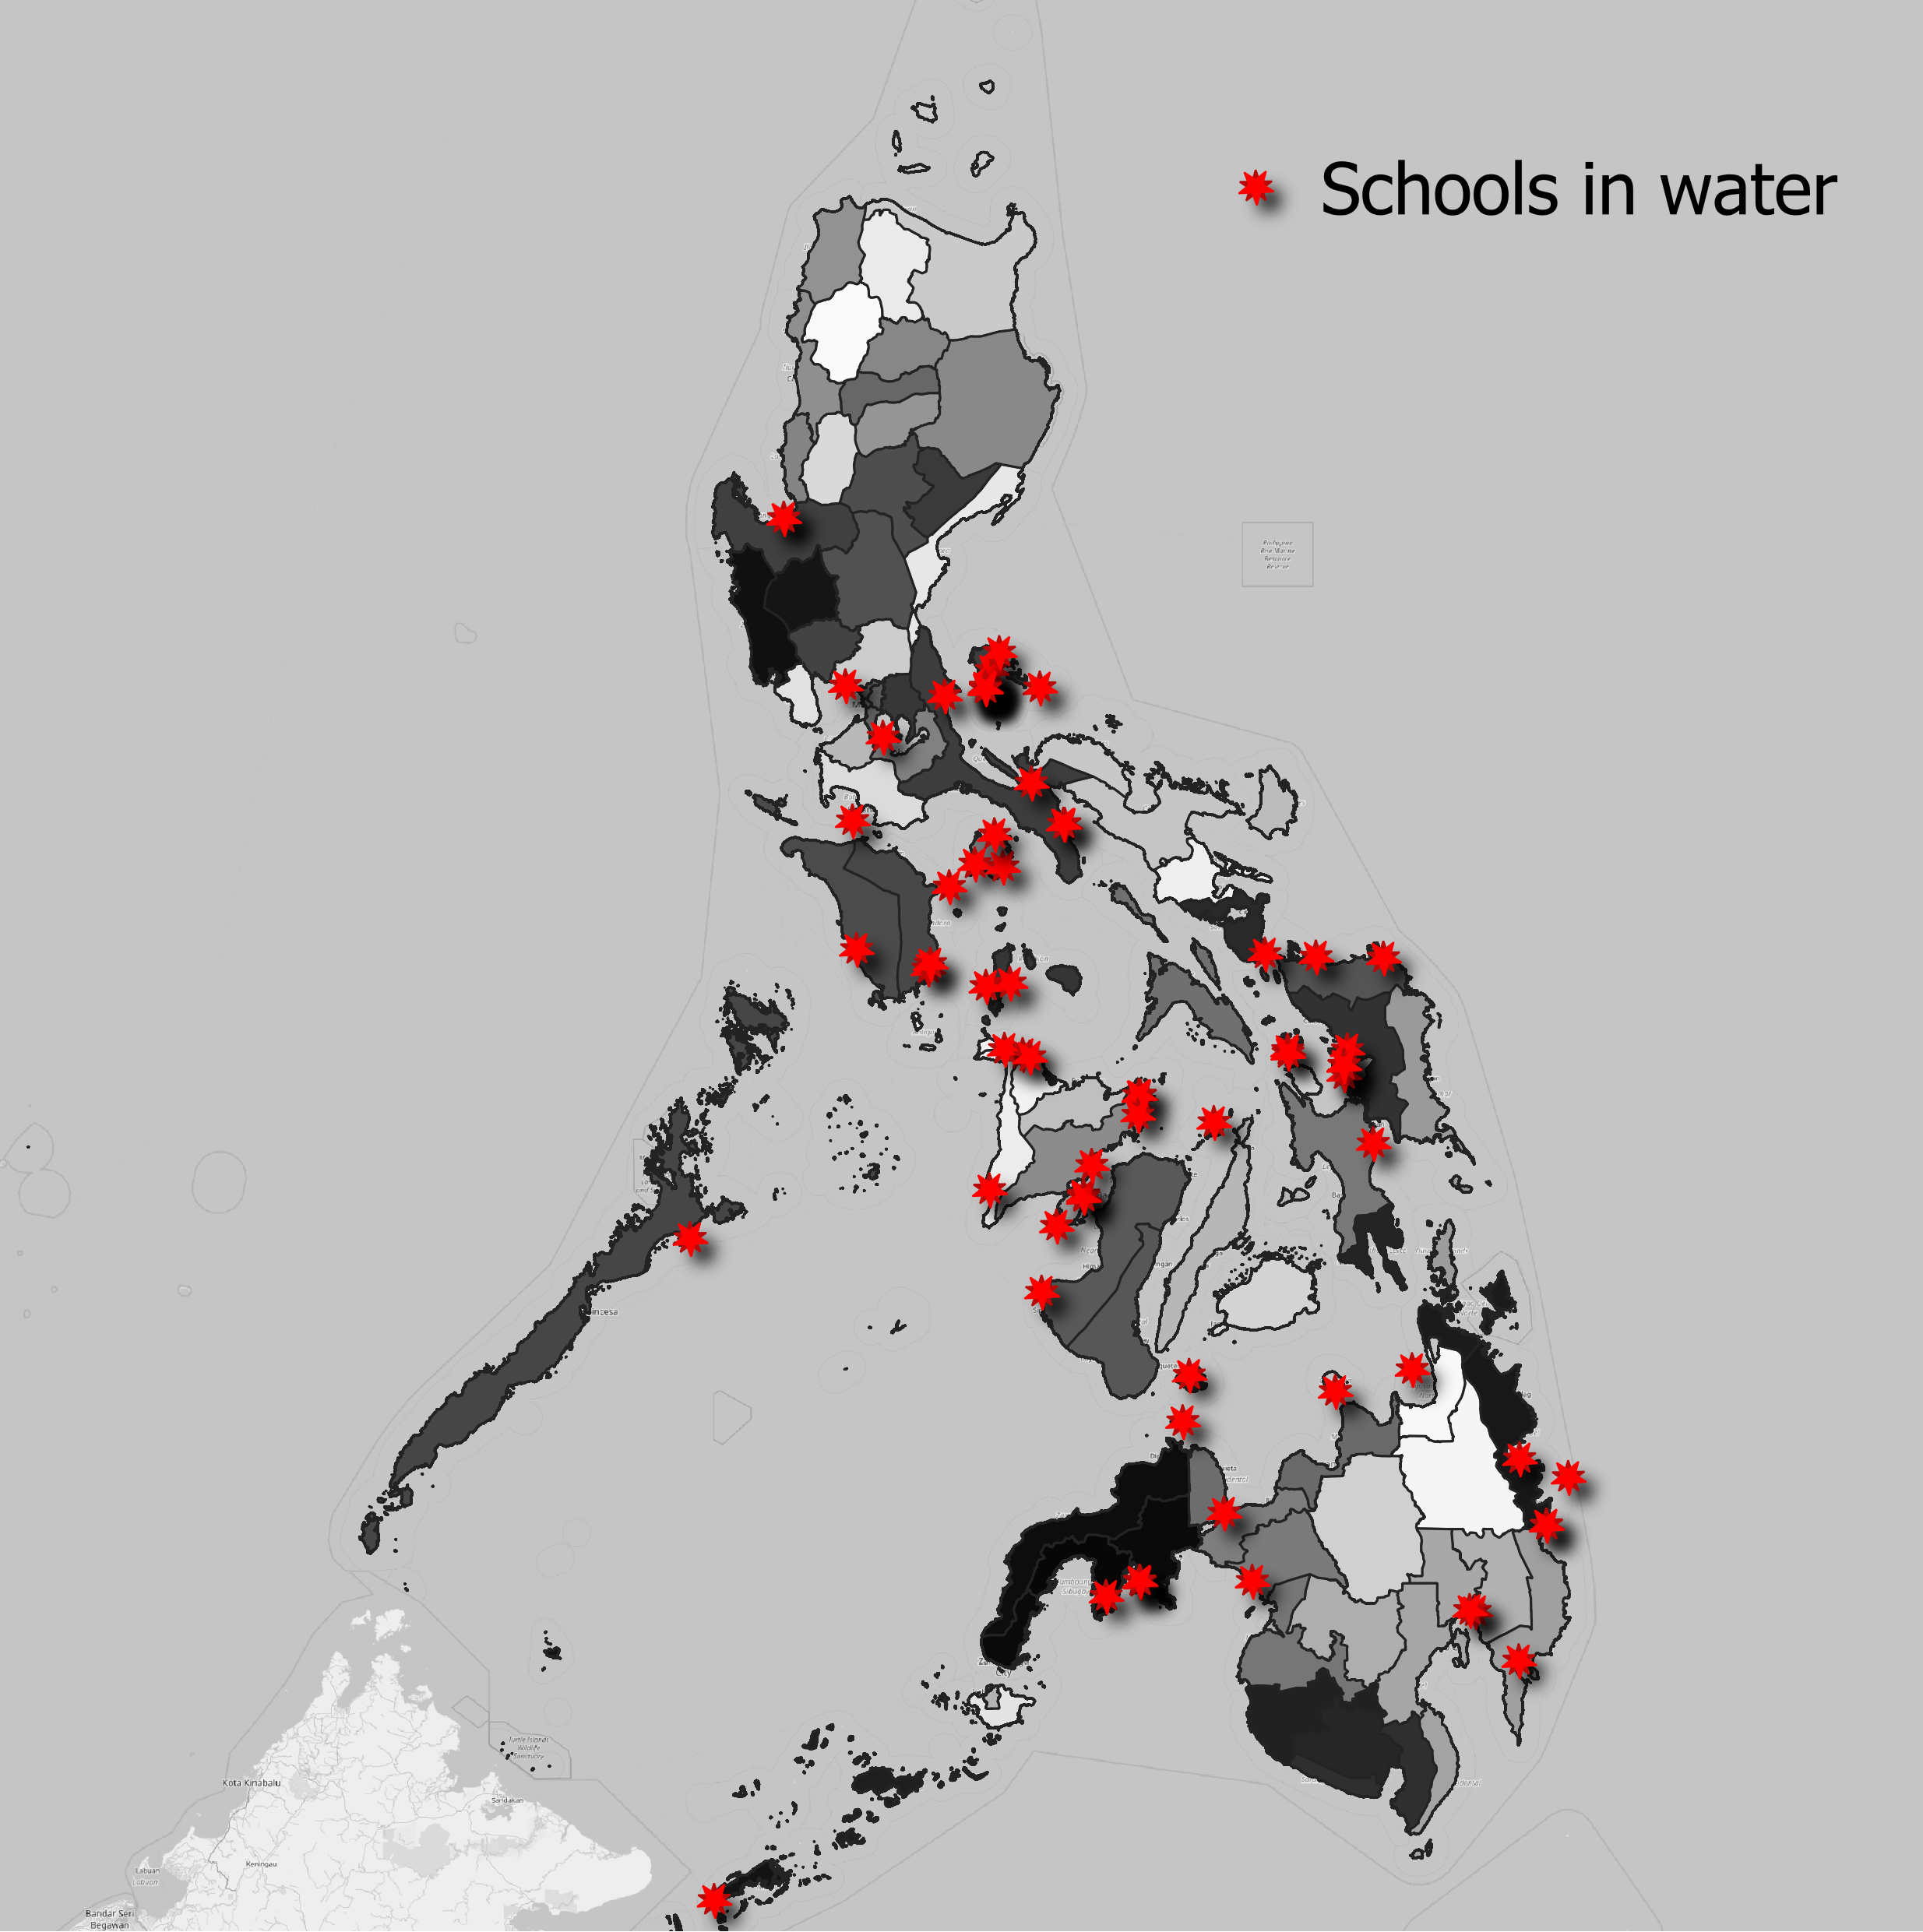

In [110]:
Image("Visuals/schools_water.png")

# Our first forecasting model: Simple exponential smoothing

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


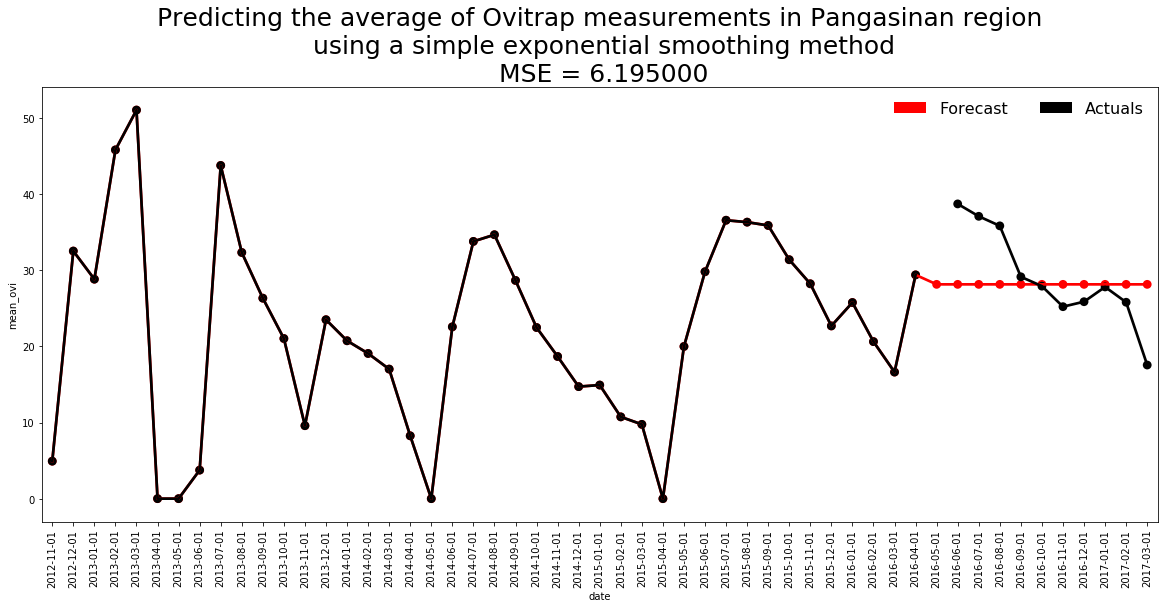

In [104]:
wrapper_ses()

# Capturing seasonality with a Seasonal ARIMA model

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.
Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


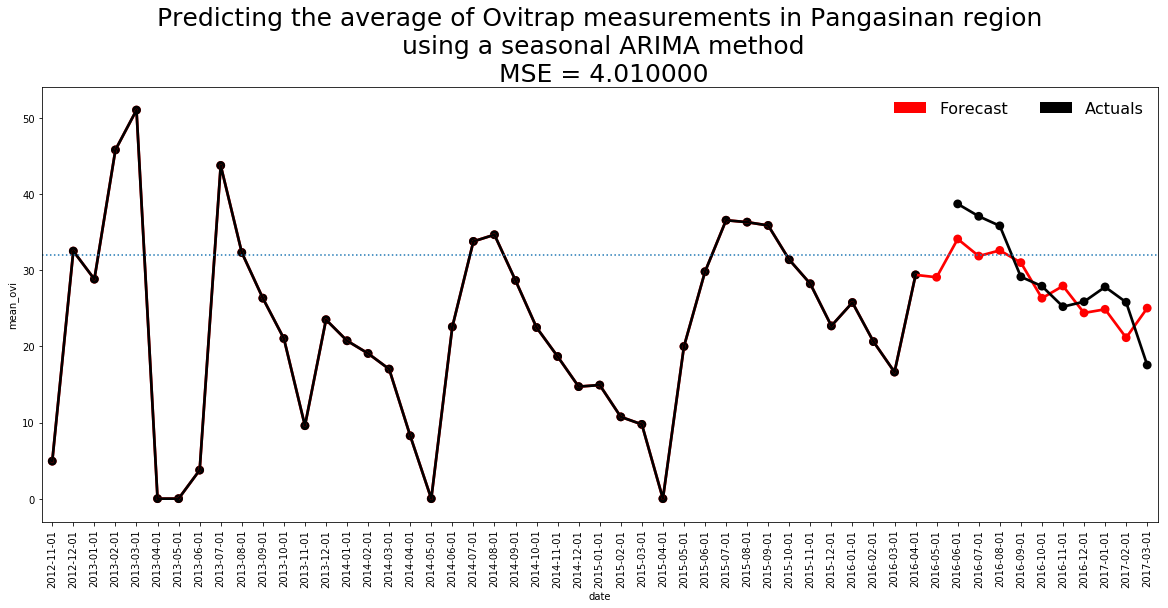

In [105]:
wrapper_arima()

# Adding exogenous variables to our model to capture soil, land and atmospherical conditions

In [109]:
Image("Visuals/variables.png")

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.
Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


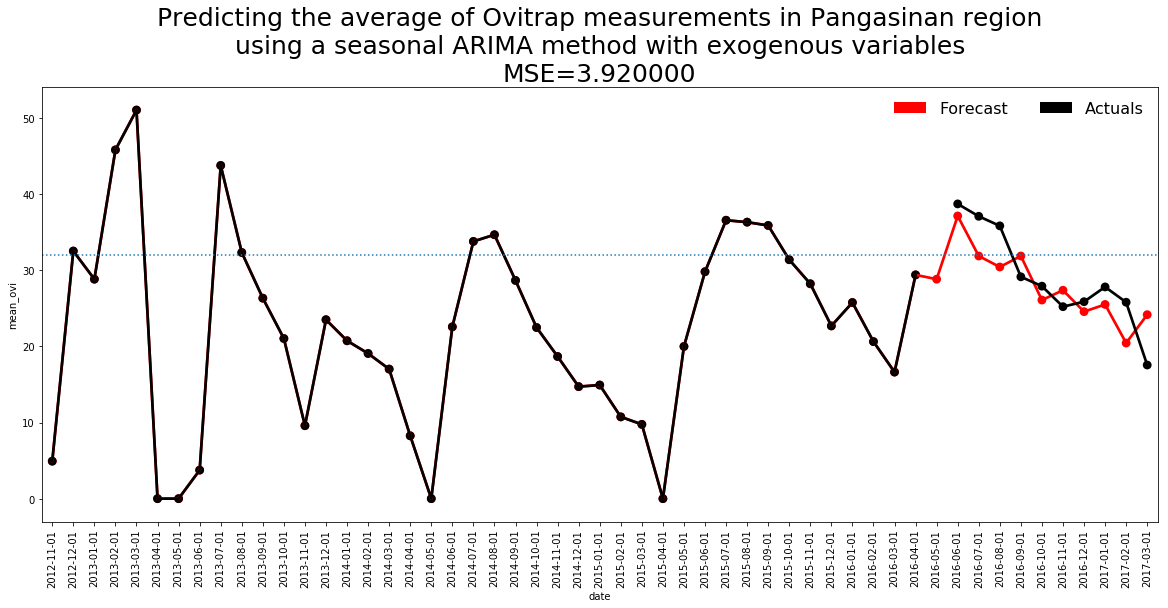

In [107]:
wrapper_exog()

# Next steps

## Redesign the geo-grid to enable us to impute missing data


In [108]:
Image("Visuals/spatial_interpolation.png")

# Additional features we got (in case you need them...)
## School level:
* ### Population density
* ### Elevation
* ### Land use (17 classes)
* ### Aggregate distance to 3 closest hospitals

## Regional level:
* ### Population density
* ### Elevation
* ### Land use (17 classes)
* ### Hospital count
 